# UNet


## Install Dependencies

In [1]:
# !pip install torchinfo --quiet

## Import Dependencies

In [2]:
# Standard Library Imports
import os
import sys

# Third-Party Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchsummary import summary

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
import sys
if 'google.colab' in sys.modules:
# Add the directory containing your module to the Python path
  module_path = '/content/drive/MyDrive/Colab_Notebooks/Session21-unet'
  sys.path.append(module_path)
  print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab_Notebooks/Session21-unet']


In [4]:
%cd  /content/drive/MyDrive/Colab_Notebooks/Session-21-unet

/content/drive/MyDrive/Colab_Notebooks/Session-21-unet


In [5]:
from utils import tensor_trimap, args_to_dict, display_loss_and_accuracies, display_output
from dataset import OxfordIIITPetsAugmented
from model import UNet
from training_utils import train, test, dice_loss

## Dataset Preparation

In [6]:
transform_dict = args_to_dict(
    pre_transform=transforms.ToTensor(),
    pre_target_transform=transforms.ToTensor(),

    common_transform=transforms.Compose([
        transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST),
    ]),

    post_transform=transforms.Compose([
        transforms.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=transforms.Compose([
        transforms.Lambda(tensor_trimap),
    ]),
)

In [7]:
train_dataset = OxfordIIITPetsAugmented(
    root='./data/OxfordPets/train',
    split="trainval",
    target_types="segmentation",
    download=True,
    **transform_dict,
)

test_dataset = OxfordIIITPetsAugmented(
    root='./data/OxfordPets/test',
    split="test",
    target_types="segmentation",
    download=True,
    **transform_dict,
)

## DataLoader Preparation

In [8]:
SEED = 8
BATCH_SIZE = 16

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=False, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Train DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

# Test DataLoader
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

CUDA Available? True


## Visualize Data

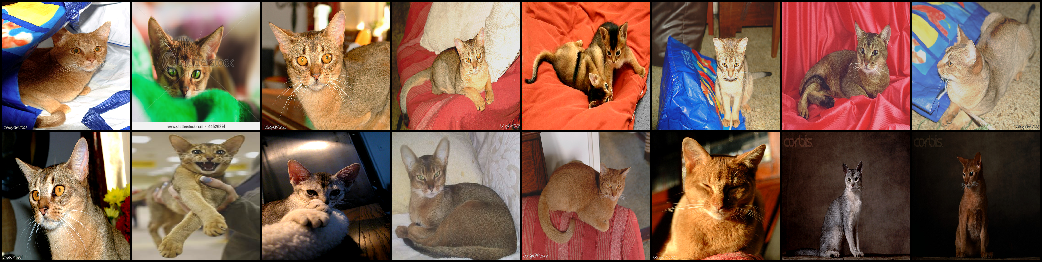

In [9]:
# Convert a pytorch tensor into a PIL image
t2img = transforms.ToPILImage()

train_pets_inputs, train_pets_targets = next(iter(train_loader))

pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
t2img(pets_input_grid)

## Visualize Masks

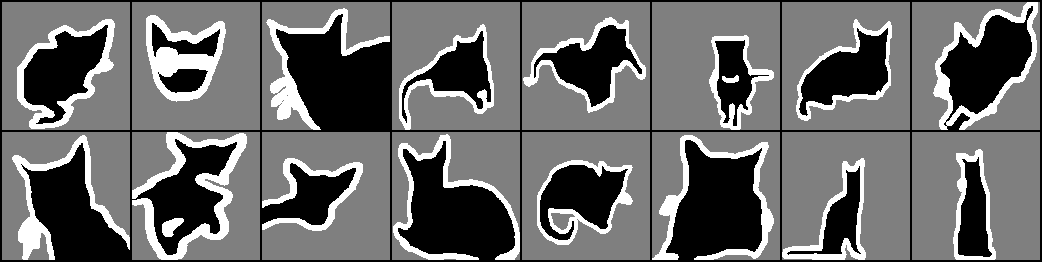

In [10]:
# When plotting the segmentation mask, we want to convert the tensor
# into a float tensor with values in the range [0.0 to 1.0]. However, the
# mask tensor has the values (0, 1, 2), so we divide by 2.0 to normalize.
pets_targets_grid = torchvision.utils.make_grid(train_pets_targets / 2.0, nrow=8)
t2img(pets_targets_grid)

## Training Parameters

In [11]:
EPOCHS = 20
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-5

## Training Run

In [12]:
def train_session(model, loss):
    """
    Function to train the model
    """
    # Data to plot accuracy and loss graphs
    train_losses = []
    test_losses = []

    # Optimization algorithm to update the weights
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Scheduler to change the learning rate after specific number of epochs
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)
    scheduler = None

    # CE OR Dice Loss
    criterion = loss

    # For each epoch
    for epoch in range(1, EPOCHS+1):
        print(" ")
        print(f'Epoch {epoch}')

        # Train the model on training dataset and append the training loss and accuracy
        train_loss = train(model, device, train_loader, optimizer, criterion, scheduler)
        train_losses.append(train_loss / len(train_loader))

        # Test the model's performance on test dataset and append the training loss and accuracy
        test_loss = test(model, device, test_loader, criterion)
        test_losses.append(test_loss)

    display_loss_and_accuracies(train_losses, test_losses)

---

## 1. Model Training - MaxPool + Transpose + Cross Entropy Loss

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

Train: Loss=0.6585 Batch_id=229: 100%|██████████| 230/230 [23:00<00:00,  6.00s/it]


Test set: Average loss: 0.7197
 
Epoch 2


Train: Loss=0.5631 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.44it/s]


Test set: Average loss: 0.6304
 
Epoch 3


Train: Loss=0.5396 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.45it/s]


Test set: Average loss: 0.5983
 
Epoch 4


Train: Loss=0.5261 Batch_id=229: 100%|██████████| 230/230 [00:26<00:00,  8.54it/s]


Test set: Average loss: 0.5820
 
Epoch 5


Train: Loss=0.4727 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.42it/s]


Test set: Average loss: 0.5731
 
Epoch 6


Train: Loss=0.4601 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.38it/s]


Test set: Average loss: 0.5079
 
Epoch 7


Train: Loss=0.4083 Batch_id=229: 100%|██████████| 230/230 [00:26<00:00,  8.54it/s]


Test set: Average loss: 0.4721
 
Epoch 8


Train: Loss=0.3830 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.39it/s]


Test set: Average loss: 0.4338
 
Epoch 9


Train: Loss=0.3651 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.31it/s]


Test set: Average loss: 0.4199
 
Epoch 10


Train: Loss=0.3511 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.22it/s]


Test set: Average loss: 0.4006
 
Epoch 11


Train: Loss=0.3290 Batch_id=229: 100%|██████████| 230/230 [00:28<00:00,  8.16it/s]


Test set: Average loss: 0.3940
 
Epoch 12


Train: Loss=0.3172 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.38it/s]


Test set: Average loss: 0.3896
 
Epoch 13


Train: Loss=0.2887 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.49it/s]


Test set: Average loss: 0.3826
 
Epoch 14


Train: Loss=0.2907 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.22it/s]


Test set: Average loss: 0.3849
 
Epoch 15


Train: Loss=0.2866 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.49it/s]


Test set: Average loss: 0.3802
 
Epoch 16


Train: Loss=0.2572 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.48it/s]


Test set: Average loss: 0.3972
 
Epoch 17


Train: Loss=0.2381 Batch_id=229: 100%|██████████| 230/230 [00:26<00:00,  8.56it/s]


Test set: Average loss: 0.3822
 
Epoch 18


Train: Loss=0.2279 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.38it/s]


Test set: Average loss: 0.3577
 
Epoch 19


Train: Loss=0.2208 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.50it/s]


Test set: Average loss: 0.3415
 
Epoch 20


Train: Loss=0.2094 Batch_id=229: 100%|██████████| 230/230 [00:26<00:00,  8.52it/s]


Test set: Average loss: 0.3381


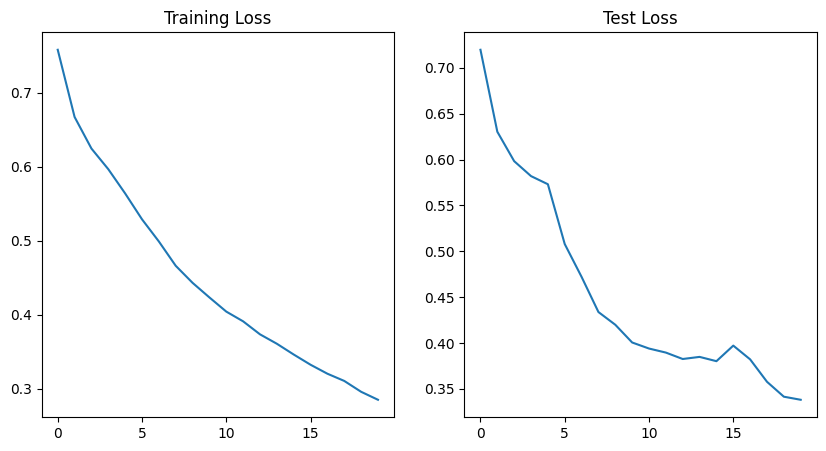

In [13]:
model = UNet(3, 3)
model = model.to('cuda')
summary(model, input_size=(3, 128, 128))

# CE Loss
criterion = nn.CrossEntropyLoss()

train_session(model, criterion)

---

## 2. Model Training - MaxPool + Transpose + Dice Loss

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

Train: Loss=0.4654 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.38it/s]


Test set: Average loss: 0.4674
 
Epoch 2


Train: Loss=0.4511 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.47it/s]


Test set: Average loss: 0.4489
 
Epoch 3


Train: Loss=0.3548 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.46it/s]


Test set: Average loss: 0.4419
 
Epoch 4


Train: Loss=0.4165 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.45it/s]


Test set: Average loss: 0.3997
 
Epoch 5


Train: Loss=0.4189 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.34it/s]


Test set: Average loss: 0.3702
 
Epoch 6


Train: Loss=0.3762 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.25it/s]


Test set: Average loss: 0.3337
 
Epoch 7


Train: Loss=0.3652 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.37it/s]


Test set: Average loss: 0.3251
 
Epoch 8


Train: Loss=0.3125 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.50it/s]


Test set: Average loss: 0.3185
 
Epoch 9


Train: Loss=0.2988 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.44it/s]


Test set: Average loss: 0.3055
 
Epoch 10


Train: Loss=0.3273 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.31it/s]


Test set: Average loss: 0.2875
 
Epoch 11


Train: Loss=0.3236 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.38it/s]


Test set: Average loss: 0.2860
 
Epoch 12


Train: Loss=0.2757 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.30it/s]


Test set: Average loss: 0.2879
 
Epoch 13


Train: Loss=0.2842 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.32it/s]


Test set: Average loss: 0.2645
 
Epoch 14


Train: Loss=0.2688 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.48it/s]


Test set: Average loss: 0.2658
 
Epoch 15


Train: Loss=0.2820 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.42it/s]


Test set: Average loss: 0.2579
 
Epoch 16


Train: Loss=0.2559 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.41it/s]


Test set: Average loss: 0.2578
 
Epoch 17


Train: Loss=0.2749 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.37it/s]


Test set: Average loss: 0.2509
 
Epoch 18


Train: Loss=0.2652 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.31it/s]


Test set: Average loss: 0.2515
 
Epoch 19


Train: Loss=0.2512 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.37it/s]


Test set: Average loss: 0.2452
 
Epoch 20


Train: Loss=0.2507 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.42it/s]


Test set: Average loss: 0.2402


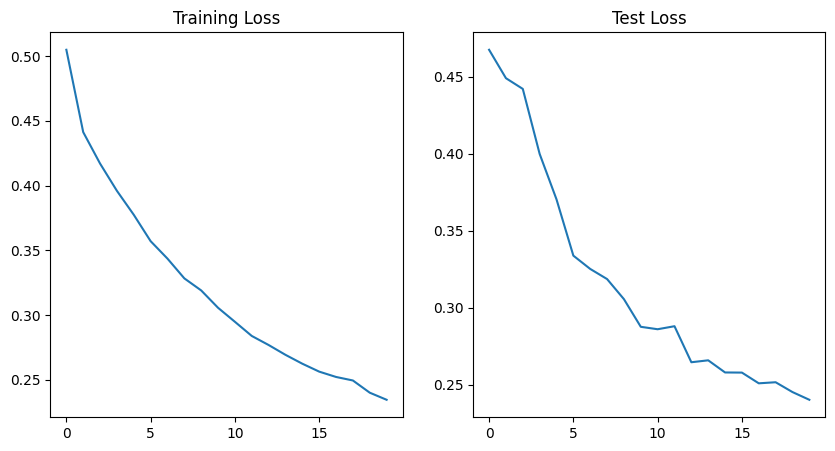

In [14]:
model = UNet(3, 3)
model = model.to('cuda')
summary(model, input_size=(3, 128, 128))

# Dice Loss
criterion = dice_loss

train_session(model, criterion)

---

## 3. Model Training - Strided Convolution + Transpose + Cross Entropy Loss

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          16,448
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

Train: Loss=0.6111 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.34it/s]


Test set: Average loss: 0.6858
 
Epoch 2


Train: Loss=0.6566 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.38it/s]


Test set: Average loss: 0.6775
 
Epoch 3


Train: Loss=0.5405 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.44it/s]


Test set: Average loss: 0.7053
 
Epoch 4


Train: Loss=0.5222 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.38it/s]


Test set: Average loss: 0.6039
 
Epoch 5


Train: Loss=0.5199 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.46it/s]


Test set: Average loss: 0.5931
 
Epoch 6


Train: Loss=0.5169 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.39it/s]


Test set: Average loss: 0.5645
 
Epoch 7


Train: Loss=0.4841 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.37it/s]


Test set: Average loss: 0.5519
 
Epoch 8


Train: Loss=0.4632 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.35it/s]


Test set: Average loss: 0.5127
 
Epoch 9


Train: Loss=0.4454 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.35it/s]


Test set: Average loss: 0.5110
 
Epoch 10


Train: Loss=0.4321 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.46it/s]


Test set: Average loss: 0.4844
 
Epoch 11


Train: Loss=0.3925 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.33it/s]


Test set: Average loss: 0.4493
 
Epoch 12


Train: Loss=0.3671 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.37it/s]


Test set: Average loss: 0.4506
 
Epoch 13


Train: Loss=0.3362 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.38it/s]


Test set: Average loss: 0.4214
 
Epoch 14


Train: Loss=0.3219 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.40it/s]


Test set: Average loss: 0.4150
 
Epoch 15


Train: Loss=0.3119 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.24it/s]


Test set: Average loss: 0.3937
 
Epoch 16


Train: Loss=0.3002 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.40it/s]


Test set: Average loss: 0.4066
 
Epoch 17


Train: Loss=0.2882 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.44it/s]


Test set: Average loss: 0.3803
 
Epoch 18


Train: Loss=0.2641 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.35it/s]


Test set: Average loss: 0.3729
 
Epoch 19


Train: Loss=0.2584 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.38it/s]


Test set: Average loss: 0.3733
 
Epoch 20


Train: Loss=0.2701 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.44it/s]


Test set: Average loss: 0.3808


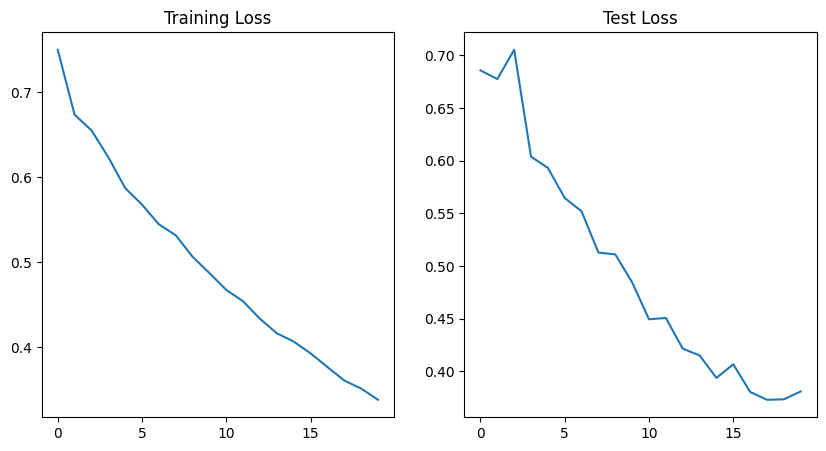

In [15]:
model = UNet(3, 3, max_pool=False)
model = model.to('cuda')
summary(model, input_size=(3, 128, 128))

# CE Loss
criterion = nn.CrossEntropyLoss()

train_session(model, criterion)

---

## 4. Model Training - Strided Convolution + Upsampling + Dice Loss

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          16,448
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

Train: Loss=0.4686 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.34it/s]


Test set: Average loss: 0.4901
 
Epoch 2


Train: Loss=0.4400 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.38it/s]


Test set: Average loss: 0.4547
 
Epoch 3


Train: Loss=0.3947 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.36it/s]


Test set: Average loss: 0.4027
 
Epoch 4


Train: Loss=0.3637 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.42it/s]


Test set: Average loss: 0.3935
 
Epoch 5


Train: Loss=0.3394 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.49it/s]


Test set: Average loss: 0.3706
 
Epoch 6


Train: Loss=0.3726 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.49it/s]


Test set: Average loss: 0.3487
 
Epoch 7


Train: Loss=0.3688 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.49it/s]


Test set: Average loss: 0.3594
 
Epoch 8


Train: Loss=0.3466 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.35it/s]


Test set: Average loss: 0.3346
 
Epoch 9


Train: Loss=0.3545 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.46it/s]


Test set: Average loss: 0.3249
 
Epoch 10


Train: Loss=0.3185 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.32it/s]


Test set: Average loss: 0.3404
 
Epoch 11


Train: Loss=0.2838 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.31it/s]


Test set: Average loss: 0.3106
 
Epoch 12


Train: Loss=0.2907 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.38it/s]


Test set: Average loss: 0.2993
 
Epoch 13


Train: Loss=0.2622 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.40it/s]


Test set: Average loss: 0.2846
 
Epoch 14


Train: Loss=0.3313 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.36it/s]


Test set: Average loss: 0.2908
 
Epoch 15


Train: Loss=0.2735 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.34it/s]


Test set: Average loss: 0.2792
 
Epoch 16


Train: Loss=0.2551 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.46it/s]


Test set: Average loss: 0.2766
 
Epoch 17


Train: Loss=0.2602 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.37it/s]


Test set: Average loss: 0.2660
 
Epoch 18


Train: Loss=0.2390 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.29it/s]


Test set: Average loss: 0.2626
 
Epoch 19


Train: Loss=0.2101 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.43it/s]


Test set: Average loss: 0.2605
 
Epoch 20


Train: Loss=0.1959 Batch_id=229: 100%|██████████| 230/230 [00:27<00:00,  8.38it/s]


Test set: Average loss: 0.2585


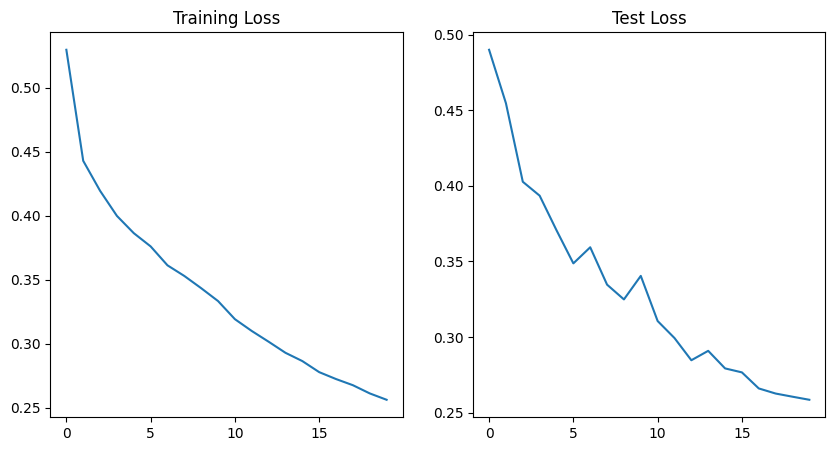

In [16]:
model = UNet(3, 3, max_pool=False, transpose=False)
model = model.to('cuda')
summary(model, input_size=(3, 128, 128))

# Dice Loss
criterion = dice_loss

train_session(model, criterion)

---

## Model Predictions

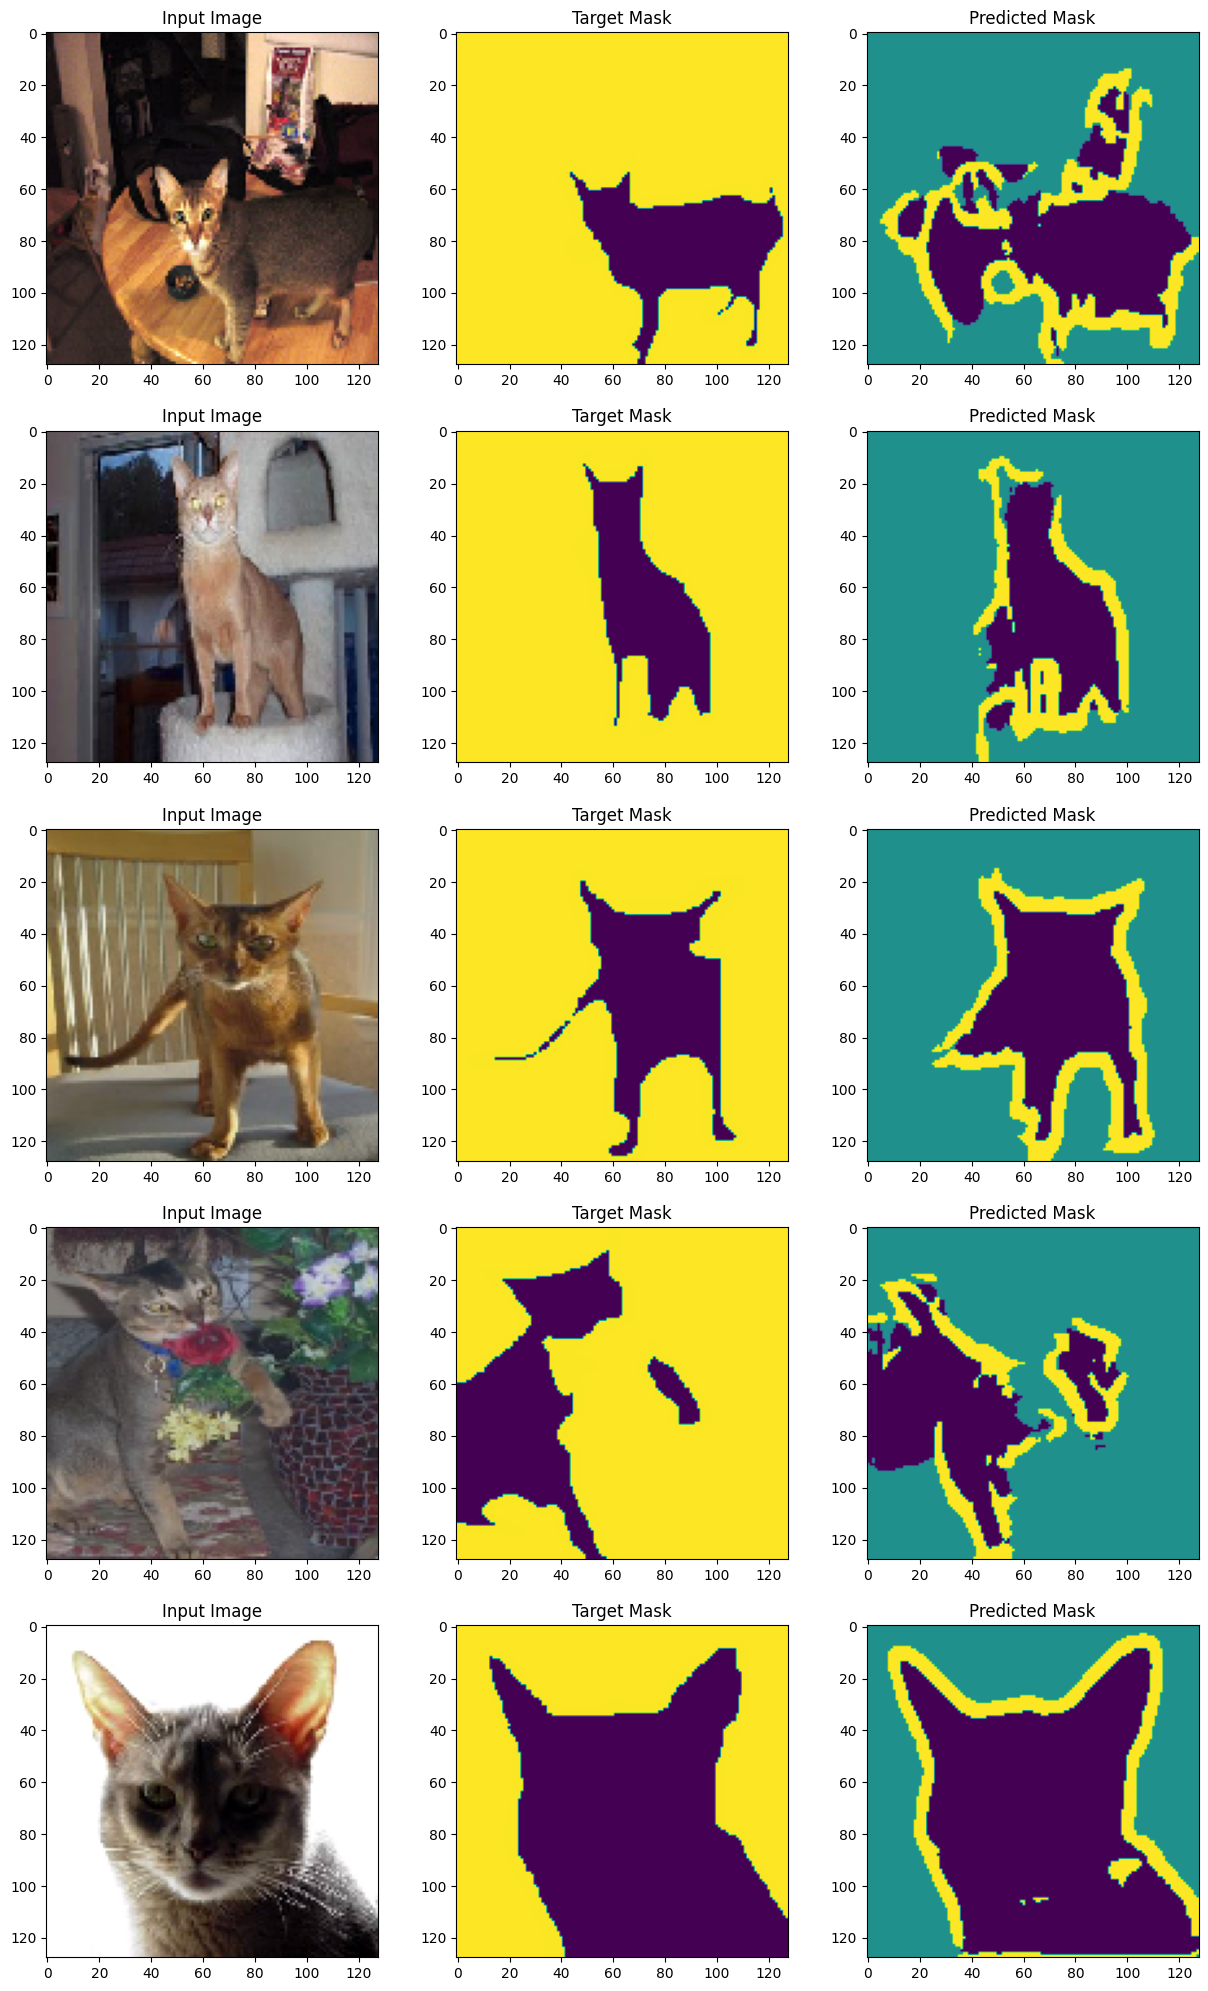

In [17]:
display_output(model, test_loader)

## Save the Model

In [18]:
torch.save(model.state_dict(), 'UNet.pth')